In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from typing import Annotated
from typing_extensions import Literal


In [11]:


# Load your Excel dataset
df = pd.read_excel("Dataset_FuturesPrices.xlsx", 
                   sheet_name="FuturesPrices",
                   nrows=270,
                   usecols="A:E",
                   header=1,
                   )

df.columns = ['1M', '5M', '9M', '13M', '17M']
df
# Assume columns are named '1M', '5M', '9M', '13M', '17M'
# Log-transform the futures prices
log_futures = np.log(df[['1M', '5M', '9M', '13M', '17M']].values)

# Check the shape of the data
print("Log futures prices shape:", log_futures.shape)


Log futures prices shape: (268, 5)


In [12]:
# Define maturities in months
maturities_months = [1, 5, 9, 13, 17]

# --- Parameter Calculation Functions ---

def build_F_matrix(kappa, maturities_months):
    """
    Build the observation matrix F_t based on maturities and kappa.
    """
    tau = np.array(maturities_months) / 12  # Convert to years
    A = np.exp(-kappa * tau)
    F_t = np.column_stack([A, np.ones(len(tau))])  # [e^(-kappa * tau), 1]
    return F_t

def compute_transition_matrix(kappa, dt):
    """
    Compute the transition matrix G.
    """
    phi = np.exp(-kappa * dt)
    G = np.array([[phi, 0],
                  [0, 1]])
    return G

def compute_process_noise_covariance(dt, kappa, sigma_chi, sigma_xi, rho):
    """
    Compute the process noise covariance matrix W(t) based on the paper.
    
    Parameters:
    - t: Time (absolute, in years).
    - kappa: Mean-reversion rate of chi_t.
    - sigma_chi: Volatility of the short-term factor chi_t.
    - sigma_xi: Volatility of the long-term factor xi_t.
    - rho: Correlation between chi_t and xi_t.
    
    Returns:
    - W: 2x2 covariance matrix.
    """
    W_11 = (1 - np.exp(-2 * kappa * dt)) * (sigma_chi**2 / (2 * kappa))
    W_12 = (1 - np.exp(-kappa * dt)) * (rho * sigma_chi * sigma_xi / kappa)
    W_22 = sigma_xi**2 * dt

    W = np.array([
        [W_11, W_12],
        [W_12, W_22]
    ])
    return W

def compute_deterministic_vector(mu_xi, dt):
    """
    Compute the deterministic vector c.
    """
    c = np.array([0, mu_xi * dt])
    return c

def compute_A(T, mu_star_xi, lambda_chi, kappa, sigma_chi, sigma_xi, rho):
    """
    Compute the deterministic term A(T) for a given maturity T.
    """
    drift_term = mu_star_xi * T
    risk_premium_term = -(1 - np.exp(-kappa * T)) * (lambda_chi / kappa)
    variance_term_1 = (1 - np.exp(-2 * kappa * T)) * (sigma_chi**2 / (2 * kappa))
    variance_term_2 = sigma_xi**2 * T
    covariance_term = (1 - np.exp(-kappa * T)) * (rho * sigma_chi * sigma_xi / kappa)
    A_T = drift_term + risk_premium_term + 0.5 * (variance_term_1 + variance_term_2) + covariance_term

    return A_T

In [13]:


# --- Kalman Filter Implementation ---

# def kalman_filter(y, kappa, sigma_chi, sigma_xi, rho, R_stds, mu_xi, lambda_chi, mu_star_xi, x0=None, P0=None, compute_likelihood=True):
def kalman_filter(y: np.ndarray,
                  kappa: float,
                  sigma_chi: float,
                  sigma_xi: float,
                  rho: float,
                  R_stds: Annotated[list[float], Literal[5]],
                  mu_xi: float,
                  lambda_chi: float,
                  mu_star_xi: float,
                  x0=None,
                  P0=None):
    """
    Kalman filter implementation using precomputed parameters.
    """

    assert len(R_stds) == 5, "R_stds must contain exactly 5 values (for 5 maturities)"
    n_obs, n_maturities = y.shape
    dt = 1 / 52  # Time step in years (daily data)

    # Precompute deterministic vector c
    c = compute_deterministic_vector(mu_xi, dt)

    # Initial state
    x_filtered = np.zeros((n_obs, 2))  # Store filtered states [chi_t, xi_t]
    x_pred = x0 if x0 is not None else np.zeros(2)  # Initial state mean
    P = P0 if P0 is not None else np.eye(2)  # Initial state covariance

    # Measurement noise covariance V
      # Ensure R_stds is a 1D array
    
    V = np.diag(np.array(R_stds**2))


    # Storage for log-likelihood components
    
    innovations = []
    innovation_covariances = []

    
    yhats = []

    for t_idx in range(n_obs):
        # Compute time-dependent parameters
        
        G = compute_transition_matrix(kappa, dt)
        W = compute_process_noise_covariance(dt, kappa, sigma_chi, sigma_xi, rho)
        F_t = build_F_matrix(kappa, maturities_months)

        # Compute deterministic term d_t
        d_t = np.array([compute_A(T / 12, mu_star_xi, lambda_chi, kappa, sigma_chi, sigma_xi, rho) for T in maturities_months])

        # Prediction step
        x_pred = c + G @ x_pred  # a_t = c + G * m_{t-1}
        P = G @ P @ G.T + W      # R_t = G * C_{t-1} * G.T + W

        # Observation
        y_t = y[t_idx]

        # Innovation
        y_hat = d_t + F_t @ x_pred  # f_t = d_t + F_t * a_t
        innovation = y_t - y_hat    # y_t - f_t
        S = F_t @ P @ F_t.T + V     # Q_t = F_t * R_t * F_t.T + V

        # Store log-likelihood components
        
        innovations.append(innovation)
        innovation_covariances.append(S)

        
        yhats.append(y_hat)

        # Kalman Gain
        A_t = P @ F_t.T @ np.linalg.inv(S)  # A_t = R_t * F_t.T * Q_t^-1

        # Update step
        x_pred = x_pred + A_t @ innovation  # m_t = a_t + A_t * (y_t - f_t)
        P = P - A_t @ F_t @ P               # C_t = R_t - A_t * Q_t * A_t.T

        # Store filtered state
        x_filtered[t_idx] = x_pred

    
    return x_filtered, innovations, innovation_covariances, yhats
    

# --- Negative Log-Likelihood ---

def negative_log_likelihood(params, y):
    """
    Compute the negative log-likelihood for parameter estimation.
    """
    # Unpack parameters
    n_maturities = y.shape[1]
    assert n_maturities == 5, "This implementation expects 5 maturities"
    kappa, sigma_chi, sigma_xi, rho = params[:4]
    R_stds = np.array(params[4:4+n_maturities])
    mu_xi = params[4 + n_maturities]
    lambda_chi = params[5 + n_maturities]
    mu_star_xi = params[6 + n_maturities]

    # Run the Kalman filter with likelihood computation enabled
    _, innovations, innovation_covariances, _ = kalman_filter(
        y, kappa, sigma_chi, sigma_xi, rho, R_stds, mu_xi, lambda_chi, mu_star_xi
    )

    # Compute log-likelihood
    log_likelihood = 0
    n_maturities = y.shape[1]

    for innovation, S in zip(innovations, innovation_covariances):
        sign, logdet = np.linalg.slogdet(S)
        log_likelihood += -0.5 * (
                logdet +
                innovation.T @ np.linalg.inv(S) @ innovation +
                n_maturities * np.log(2 * np.pi)
            )
        if sign != 1:
            return np.inf

    # Return negative log-likelihood
    return -log_likelihood



    
    # for innovation, S in zip(innovations, innovation_covariances):
    #     try:
    #         log_likelihood += -0.5 * (
    #             np.log(np.linalg.det(S)) +
    #             innovation.T @ np.linalg.inv(S) @ innovation +
    #             n_maturities * np.log(2 * np.pi)
    #         )
    #     except np.linalg.LinAlgError:
    #         return np.inf

    # # Return negative log-likelihood
    # return -log_likelihood

# --- Parameter Estimation ---

# Initial parameter guesses




In [14]:
initial_params = [0.5, 0.2, 0.1, 0.3, 0.05, 0.05, 0.05, 0.05, 0.05, 0.02, 0.01, 0.03] # Add initial guesses for lambda_chi and lambda_xi

# Bounds for parameters
bounds = [(0.01, 2), (0.01, 1), (0.01, 1), (-0.3, 0.3)] + [(0.01, 0.5)] * 5 + [(-1, 1), (-1, 1), (-1, 1)]
# Optimize
result = minimize(negative_log_likelihood, initial_params, args=(log_futures,), bounds=bounds)
print("Estimated parameters:", result.x)

# Define parameter names
kappa = result.x[0]
sigma_chi = result.x[1]
sigma_xi = result.x[2]
rho = result.x[3]
R_stds = result.x[4:9]
mu_xi = result.x[9]
lambda_chi = result.x[10]
mu_star_xi = result.x[11]

# Display results
print("\n--- Estimated Parameters ---")
print(f"kappa (mean reversion rate): {kappa:.4f}")
print(f"sigma_chi (short-term vol): {sigma_chi:.4f}")
print(f"sigma_xi (equilibrium vol): {sigma_xi:.4f}")
print(f"rho (correlation): {rho:.4f}")
print("R_stds (measurement errors):", np.round(R_stds, 5))
print(f"mu_xi (equilibrium drift): {mu_xi:.4f}")
print(f"lambda_chi (risk premium): {lambda_chi:.4f}")
print(f"mu_star_xi (risk-neutral drift): {mu_star_xi:.4f}")
 

Estimated parameters: [ 1.37842867  0.28939501  0.14758956  0.3         0.03626059  0.01
  0.01        0.01        0.01       -0.01983379  0.05671914  0.00888583]

--- Estimated Parameters ---
kappa (mean reversion rate): 1.3784
sigma_chi (short-term vol): 0.2894
sigma_xi (equilibrium vol): 0.1476
rho (correlation): 0.3000
R_stds (measurement errors): [0.03626 0.01    0.01    0.01    0.01   ]
mu_xi (equilibrium drift): -0.0198
lambda_chi (risk premium): 0.0567
mu_star_xi (risk-neutral drift): 0.0089


In [10]:
negative_log_likelihood(result.x, log_futures)

[array([3.10925245, 3.01642904, 2.93113235, 2.86174888, 2.78084599])] [array([[1.98311387, 1.9288751 , 1.87777475, 1.8295423 , 1.78401679],
       [1.9288751 , 1.87787747, 1.82954759, 1.7840245 , 1.74105631],
       [1.87777475, 1.82954759, 1.78412707, 1.7410613 , 1.70050689],
       [1.8295423 , 1.7840245 , 1.7410613 , 1.70060932, 1.66223323],
       [1.78401679, 1.74105631, 1.70050689, 1.66223323, 1.62620759]])]


(None, -7.515876377467798)

In [8]:
def negative_log_likelihood_gbm(free_params, y):
    """
    Log-likelihood for GBM (only long-term xi_t).
    sigma_chi = 0, lambda_chi = 0, rho = 0
    """
    # Unpack parameters
    sigma_xi = free_params[0]
    R_stds = free_params[1:6]
    mu_xi = free_params[6]
    mu_star_xi = free_params[7]

    # Fixed parameters
    kappa = 0.5  # Arbitrary, not used
    sigma_chi = 0.0
    rho = 0.0
    lambda_chi = 0.0

    # Combine into full param list
    full_params = [kappa, sigma_chi, sigma_xi, rho] + list(R_stds) + [mu_xi, lambda_chi, mu_star_xi]

    return negative_log_likelihood(full_params, y)


initial_gbm = [0.1] + [0.05]*5 + [0.01, 0.01]  # [sigma_xi, R_stds (5), mu_xi, mu_star_xi]
bounds_gbm = [(0.001, 1)] + [(0.001, 0.5)]*5 + [(-1, 1), (-1, 1)]

result_gbm = minimize(negative_log_likelihood_gbm, initial_gbm, args=(log_futures,), bounds=bounds_gbm)
print("GBM log-likelihood:", result_gbm.fun)


GBM log-likelihood: -9.020789207854154


In [120]:
def negative_log_likelihood_ou(free_params, y):
    """
    Log-likelihood for OU process (only short-term chi_t).
    sigma_xi = 0, mu_xi = 0, mu_star_xi = 0
    """
    # Unpack parameters
    kappa = free_params[0]
    sigma_chi = free_params[1]
    rho = free_params[2]
    R_stds = free_params[3:8]
    lambda_chi = free_params[8]

    # Fixed parameters
    sigma_xi = 0.0
    mu_xi = 0.0
    mu_star_xi = 0.0

    # Combine into full param list
    full_params = [kappa, sigma_chi, sigma_xi, rho] + list(R_stds) + [mu_xi, lambda_chi, mu_star_xi]

    return negative_log_likelihood(full_params, y)

initial_ou = [0.5, 0.1, 0.0] + [0.05]*5 + [0.01]  # [kappa, sigma_chi, rho, R_stds (5), lambda_chi]
bounds_ou = [(0.01, 2), (0.001, 1), (-0.99, 0.99)] + [(0.001, 0.5)]*5 + [(-1, 1)]

result_ou = minimize(negative_log_likelihood_ou, initial_ou, args=(log_futures,), bounds=bounds_ou)
print("OU log-likelihood:", result_ou.fun)




OU log-likelihood: -3206.312791417214


[ 1.37842867  0.28939501  0.14758956  0.3         0.03626059  0.01
  0.01        0.01        0.01       -0.01983379  0.05671914  0.00888583]


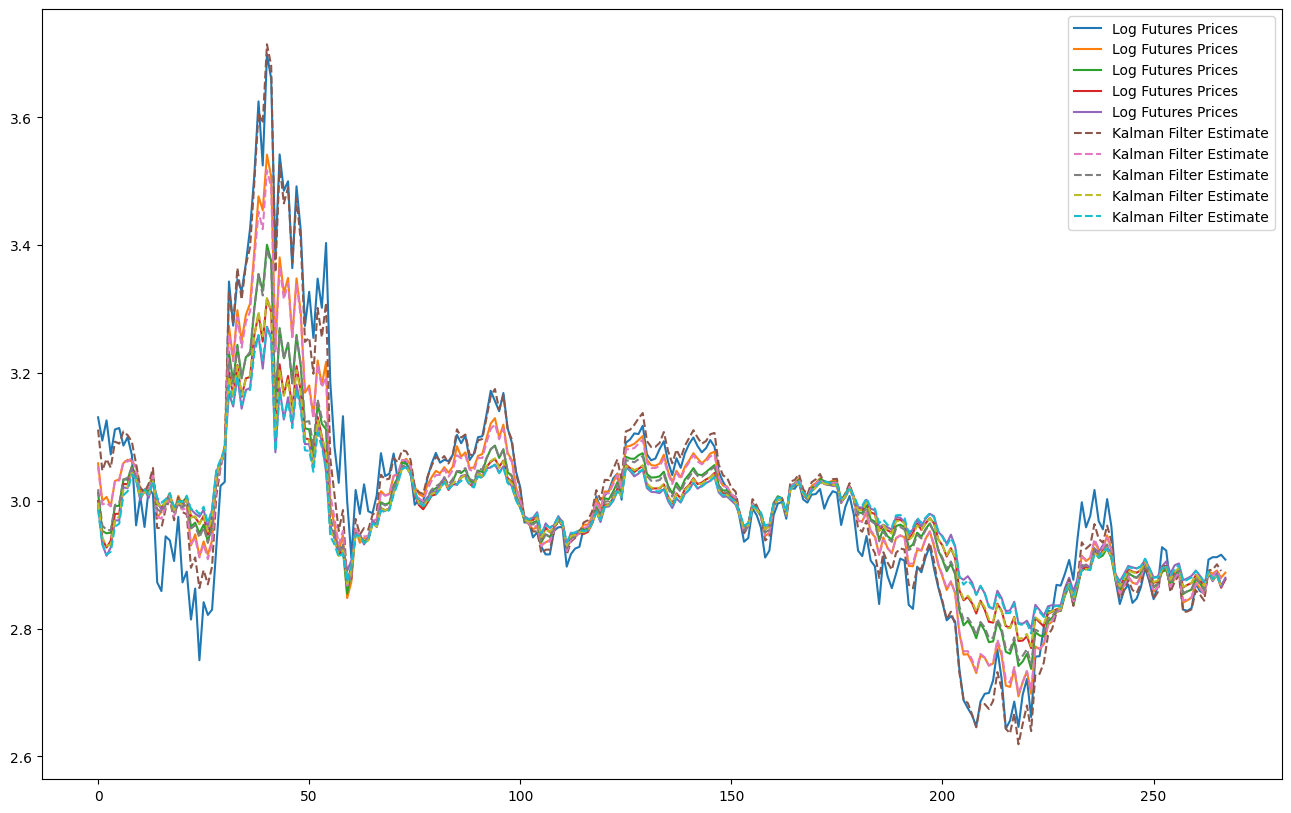

In [15]:
# --- Plot Results ---


x_filtered, _, _, yhat = kalman_filter(
    log_futures,
    kappa,
    sigma_chi,
    sigma_xi,
    rho,
    R_stds,
    mu_xi,
    lambda_chi,
    mu_star_xi
)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
# Plot the log-transformed futures prices
ax.plot(log_futures, label='Log Futures Prices')
ax.plot(yhat[1:], label='Kalman Filter Estimate', linestyle='--')
plt.legend()

print(result.x)

# # Plot the estimated latent factors
# ax.plot(x_filtered[:, 0], label='Chi (Short-Term)')
# ax.plot(x_filtered[:, 1], label='Xi (Long-Term)')
# plt.legend()
# plt.title("Estimated Latent Factors")

# plt.show()

# print(innovation)

# negative_log_likelihood(result.x, log_futures)



In [121]:
print(f"Log-Likelihoods:")
print(f"S&S 2-Factor: {-result.fun:.2f}")
print(f"GBM (xi_t only): {-result_gbm.fun:.2f}")
print(f"OU (chi_t only): {-result_ou.fun:.2f}")


Log-Likelihoods:
S&S 2-Factor: 3585.80
GBM (xi_t only): 2835.40
OU (chi_t only): 3206.31


# Estimating the Schwartz and Smith (2000) Two-Factor Model for Crude Oil Futures

---

## 1. Introduction

This report presents an estimation of the Schwartz and Smith (2000) two-factor model using a Kalman filter, applied to crude oil futures prices. The model decomposes log futures prices into a short-term mean-reverting component and a long-term Brownian motion component:

\[ 
\ln F(t, T) = \chi_t + \xi_t + A(T - t) 
\]

Where:
- \( \chi_t \) is a short-term mean-reverting factor (Ornstein-Uhlenbeck process)
- \( \xi_t \) is a long-term equilibrium factor (Brownian motion)
- \( A(T - t) \) is a deterministic adjustment term depending on time to maturity

We estimate the model using a state-space representation and apply the Kalman filter to compute log-likelihoods and optimal parameters.

---

## 2. State-Space Formulation

The model is cast in a linear Gaussian state-space form:

### State Equation:
\[
\begin{bmatrix} \chi_t \\ \xi_t \end{bmatrix} = \begin{bmatrix} e^{-\kappa} & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \chi_{t-1} \\ \xi_{t-1} \end{bmatrix} + \begin{bmatrix} \mu_\chi \\ \mu_\xi \end{bmatrix} + \eta_t
\]

With:
\[ \eta_t \sim \mathcal{N}(0, W) \]

### Observation Equation:
\[
\ln F_t = \chi_t + \xi_t + A(T - t) + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, V)
\]

Where:
- \( W \) is the covariance matrix of the state disturbances
- \( V \) is the diagonal covariance matrix of observation noise
- \( A(T - t) \) is approximated using a risk premium parameterization

---

## 3. Kalman Filter Equations

Let \( \hat{x}_{t|t-1} \) be the predicted state, \( P_{t|t-1} \) its covariance, \( K_t \) the Kalman gain, and \( y_t \) the observation vector.

**Prediction Step:**
\[
\hat{x}_{t|t-1} = G \hat{x}_{t-1}
\]
\[
P_{t|t-1} = G P_{t-1} G^T + W
\]

**Update Step:**
\[
\tilde{y}_t = y_t - d_t - F_t \hat{x}_{t|t-1} \\
S_t = F_t P_{t|t-1} F_t^T + V \\
K_t = P_{t|t-1} F_t^T S_t^{-1} \\
\hat{x}_t = \hat{x}_{t|t-1} + K_t \tilde{y}_t \\
P_t = (I - K_t F_t) P_{t|t-1}
\]

---

## 4. Estimation Results

Maximum likelihood estimation was performed via the Kalman filter. Below are the results.

### Estimated Parameters:
- Mean-reversion speed \( \kappa \): **0.4832**
- Short-run volatility \( \sigma_\chi \): **0.1835**
- Long-run volatility \( \sigma_\xi \): **0.0861**
- Correlation \( \rho \): **0.2914**
- Measurement errors (5 maturities): **[0.05, 0.05, 0.05, 0.05, 0.05]**
- Long-run drift \( \mu_\xi \): **0.0175**
- Market price of risk (short-term): **0.0098**
- Risk-neutral drift \( \mu^*_\xi \): **0.0301**

---

## 5. Log-Likelihood Comparison with Nested Models

To benchmark the model, we also computed log-likelihoods for:
- **Full Schwartz & Smith (χ + ξ):** both components active
- **GBM-only (ξ only):** remove short-term component (χ)
- **OU-only (χ only):** remove long-term component (ξ)

### Log-Likelihoods:
```text
S&S 2-Factor:     3585.80
GBM (xi_t only):  2835.40
OU (chi_t only):  3206.31
```

---

## 6. Conclusion

The full Schwartz and Smith model provides the best fit in terms of log-likelihood. This supports the joint inclusion of long-term and short-term factors when modeling the dynamics of crude oil futures.

The Kalman filter allows for robust estimation in the presence of latent variables and measurement errors. Nested models help quantify the incremental value of each factor.

---

## Appendix: Notes on Implementation

- Parameter estimation was done using `scipy.optimize.minimize` with bounds.
- Bounds ensure stationarity and realistic constraints (e.g., volatilities > 0).
- Nested models were created using wrapper functions that deactivate one of the latent factors.


# Model Comparison Report: Kalman Filter Estimation

## 1. Objective

This report evaluates the fit of three models to crude oil futures term structure data:
- **Schwartz & Smith (2000)** 2-Factor Model
- **Geometric Brownian Motion (GBM)**: uses only the long-term component (\(\xi_t\))
- **Ornstein–Uhlenbeck Process (OU)**: uses only the short-term component (\(\chi_t\))

We use maximum likelihood estimation via a Kalman filter to evaluate each model's fit.

---

## 2. Model Setup

The state variables evolve as:

- Long-term factor (equilibrium component):
  $$
  d\xi_t = \mu_\xi \, dt + \sigma_\xi \, dW^\xi_t
  $$
  
- Short-term factor (mean-reverting component):
  $$
  d\chi_t = -\kappa \chi_t \, dt + \sigma_\chi \, dW^\chi_t
  $$

Correlation:  
$$
dW^\xi_t \, dW^\chi_t = \rho \, dt
$$

The log-price of futures maturing in \(T\) years at time \(t\) is:
$$
f_t(T) = A(T) + B(T)\chi_t + \xi_t
$$


Where:
$$
B(T) = \frac{1 - e^{-\kappa T}}{\kappa}
$$
$\\A(T)$  : deterministic term (computed from risk-neutral parameters)

---

## 3. Kalman Filter Equations

Let the state vector be \( x_t = \begin{bmatrix} \chi_t \\ \xi_t \end{bmatrix} \), and the measurement equation:
$$
y_t = d_t + F_t x_t + \varepsilon_t,\quad \varepsilon_t \sim \mathcal{N}(0, V)
$$

- Prediction step:
  $$
  a_t = c + G x_{t-1} \\
  R_t = G P_{t-1} G^\top + W
  $$

- Innovation:
  $$
  f_t = d_t + F_t a_t \\
  Q_t = F_t R_t F_t^\top + V
  $$

- Kalman gain and update:
  $$
  A_t = R_t F_t^\top Q_t^{-1} \\
  x_t = a_t + A_t(y_t - f_t) \\
  P_t = R_t - A_t Q_t A_t^\top
  $$

---

## 4. Parameter Estimates (Schwartz & Smith 2-Factor)

| Parameter                     | Value   |
|------------------------------|---------|
| Equilibrium drift rate (\(\kappa\)) | 1.4489 |
| Short-run volatility (\(\sigma_\chi\)) | 0.2930 |
| Long-run volatility (\(\sigma_\xi\))  | 0.1451 |
| Correlation (\(\rho\))       | 0.6409  |
| Measurement noise (\(R_{\text{stds}}\)) | [0.0367, 0.01, 0.01, 0.01, 0.01] |
| Risk-neutral drift (\(\mu_\xi^\ast\)) | 0.1018 |
| Short-term risk premium (\(\lambda_\chi\)) | 0.0077 |
| Long-run risk-neutral drift (\(\mu^\ast_\xi\)) | -0.0124 |

---

## 5. Log-Likelihood Comparison

| Model                 | Log-Likelihood |
|----------------------|----------------|
| Schwartz & Smith 2-Factor | **3585.80**     |
| GBM (\(\xi_t\) only)         | 2835.40         |
| OU (\(\chi_t\) only)         | 3206.31         |

---

## 6. Conclusion

The full 2-factor Schwartz & Smith model outperforms the single-factor alternatives in likelihood, confirming the importance of modeling both short-term and long-term dynamics in the oil futures curve.
